In [1]:
!pip install torchtext==0.8.0

     |████████████████████████████████| 7.0MB 7.4MB/s 
  Found existing installation: torchtext 0.9.1
    Uninstalling torchtext-0.9.1:
      Successfully uninstalled torchtext-0.9.1


In [2]:
!pip install git+https://github.com/AmrMKayid/nam

  Cloning https://github.com/AmrMKayid/nam to /tmp/pip-req-build-nlv4jtex
  Running command git clone -q https://github.com/AmrMKayid/nam /tmp/pip-req-build-nlv4jtex
     |████████████████████████████████| 776.8MB 22kB/s 
  Created wheel for nam: filename=nam-0.0.1-cp37-none-any.whl size=23133 sha256=de07b22963689413db313c0d7836817bf851a540532af792e11df73923c5976f
  Stored in directory: /tmp/pip-ephem-wheel-cache-8usz84et/wheels/a8/94/67/d5a46684a760631403219fefe519c9bfe86236e3fab8428383
Successfully built nam
ERROR: torchvision 0.9.1+cu101 has requirement torch==1.8.1, but you'll have torch 1.7.0 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101


In [3]:
!pip install pytorch-lightning

     |████████████████████████████████| 849kB 7.4MB/s 
     |████████████████████████████████| 184kB 13.6MB/s 
     |████████████████████████████████| 276kB 11.6MB/s 
     |████████████████████████████████| 112kB 20.9MB/s 
     |████████████████████████████████| 829kB 20.5MB/s 
     |████████████████████████████████| 1.3MB 38.8MB/s 
     |████████████████████████████████| 296kB 55.1MB/s 
     |████████████████████████████████| 143kB 52.9MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp37-cp37m-linux_x86_64.whl size=44620 sha256=40c0e4e251ac468a220a8d34bdfdb7d6c234a45ea25f4453ab7728cec7008aa0
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491058 sha256=9abe96ce8984663ab6d58bf354337b4cbc208c31286ca392e360ccf9979390ec
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built PyYAML

In [4]:
!pip install loguru

     |████████████████████████████████| 61kB 5.0MB/s 


In [5]:
#!pip install git+https://github.com/PyTorchLightning/pytorch-lightning
import pytorch_lightning as pl
print(pl.__version__)

1.2.8


In [1]:
from sklearn.model_selection import train_test_split

from nam.data import *
from nam.config import defaults
from nam.models import NAM, DNN, get_num_units, FeatureNN
from nam.engine import Engine
#from nam.utils import graphing
#from nam.utils.graphing import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, WeightedRandomSampler, TensorDataset
from torch.optim.lr_scheduler import StepLR
import pytorch_lightning as pl

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import numpy as np
import pandas as pd
import copy
from time import time


In [2]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
housing_df = pd.DataFrame(data=housing.data, columns=housing.feature_names)
housing_df['target'] = housing.target

In [3]:
housing_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [60]:
config = defaults()
config.dropout = 0
config.activation='exu'
config.feature_dropout = 0
config.n_models = 5
config.regression = True
config.hidden_sizes = [128]
#config.hidden_sizes = [64]

In [61]:
config

Config(activation='exu', batch_size=1024, cross_val=False, data_split=1, debug=False, decay_rate=0.995, device='cuda', dropout=0, feature_dropout=0, fold_num=1, hidden_sizes=[128], l2_regularization=0.0, lr=0.01, n_folds=5, n_models=5, num_basis_functions=1000, num_splits=3, num_units=64, num_workers=16, optimizer='adam', output_dir='output', output_regularization=0.0, patience=10, regression=True, seed=1377, shuffle=True, test_split=0.2, training_epochs=3, units_multiplier=2, use_dnn=False)

In [62]:
housing.feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [63]:
dataset = NAMDataset.from_df(config,
                             housing_df, 
                             features_columns= housing.feature_names,
                             targets_column='target')

In [64]:
train_dl, val_dl, test_dl = dataset.get_dataloaders()

In [65]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

models = []
for n in range(config.n_models):
    models.append(NAM(
        config=config,
        name="NAMModel_housing",
        num_inputs=len(dataset[0][0]),
        num_units=get_num_units(config, dataset.features),
    ))

for model in models:
  model = model.to(device)

In [66]:
models[0]

NAM(
  (feature_nns): Sequential(
    (FeatureNN_0): FeatureNN(
      (model): ModuleList(
        (0): LinReLU(in_features=1000, out_features=128)
        (1): Linear(in_features=128, out_features=1, bias=True)
      )
    )
    (FeatureNN_1): FeatureNN(
      (model): ModuleList(
        (0): LinReLU(in_features=104, out_features=128)
        (1): Linear(in_features=128, out_features=1, bias=True)
      )
    )
    (FeatureNN_2): FeatureNN(
      (model): ModuleList(
        (0): LinReLU(in_features=1000, out_features=128)
        (1): Linear(in_features=128, out_features=1, bias=True)
      )
    )
    (FeatureNN_3): FeatureNN(
      (model): ModuleList(
        (0): LinReLU(in_features=1000, out_features=128)
        (1): Linear(in_features=128, out_features=1, bias=True)
      )
    )
    (FeatureNN_4): FeatureNN(
      (model): ModuleList(
        (0): LinReLU(in_features=1000, out_features=128)
        (1): Linear(in_features=128, out_features=1, bias=True)
      )
    )
    (Fe

In [67]:
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()

    running_loss = 0.0
    
    start_time = time()
    for batch_idx, (data, target) in enumerate(train_loader):   
        optimizer.zero_grad()   # .backward() accumulates gradients
        data = data.to(device)
        target = target.to(device) # all data & model on same device

        outputs = model(data)[0]
        loss = criterion(outputs, target)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()
    
    end_time = time()
    
    running_loss /= len(train_loader)
    print('Training Loss: ', running_loss, 'Time: ',end_time - start_time, 's')
    return running_loss

def test_model(model, test_loader, criterion):
    with torch.no_grad():
        model.eval()

        running_loss = 0.0

        Y_pred, Y = [], []
        for batch_idx, (data, target) in enumerate(test_loader):   
            data = data.to(device)
            target = target.to(device)

            outputs = model(data)[0]
            loss = criterion(outputs, target).detach()
            running_loss += loss.item()

            pred = outputs.cpu().detach()

            Y_pred.append(pred)
            Y.append(target.cpu())

        running_loss /= len(test_loader)
        Y_pred = torch.cat(Y_pred)
        Y = torch.cat(Y)
        r2 = r2_score(Y, Y_pred)
        print("Testing r2_score : "+str(i)+" :",r2)
        print('Testing Loss: ', running_loss)
        return running_loss, r2


In [68]:
count = 0
for model in models:
  model.train()
  criterion = torch.nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = 0.00674, weight_decay=1e-6)
  scheduler = StepLR(optimizer, step_size=20, gamma=0.1)
  print("model_No : ", count)
  count += 1
  for i in range(50):
    print("epoch no:", i)
    train_loss = train_epoch(model, train_dl, criterion, optimizer)
    test_loss, r2 = test_model(model, val_dl, criterion)
    scheduler.step()

model_No :  0
epoch no: 0
Training Loss:  527.9108285268147 Time:  1.853940725326538 s
Testing r2_score : 0 : -29.139825668610502
Testing Loss:  39.39974403381348
epoch no: 1
Training Loss:  11.05585809548696 Time:  1.946836233139038 s
Testing r2_score : 1 : -0.6113085565134324
Testing Loss:  2.0929776430130005
epoch no: 2
Training Loss:  1.5257321000099182 Time:  1.9234654903411865 s
Testing r2_score : 2 : 0.4085853850572454
Testing Loss:  0.7647320628166199
epoch no: 3
Training Loss:  0.7460725506146749 Time:  1.8839740753173828 s
Testing r2_score : 3 : 0.5023345065975444
Testing Loss:  0.6568479537963867
epoch no: 4
Training Loss:  0.582691905895869 Time:  1.8764746189117432 s
Testing r2_score : 4 : 0.5668181956039204
Testing Loss:  0.5678794384002686
epoch no: 5
Training Loss:  0.5418907741705576 Time:  1.8509235382080078 s
Testing r2_score : 5 : 0.5828556375067642
Testing Loss:  0.5487262606620789
epoch no: 6
Training Loss:  0.5236501236756642 Time:  1.855421781539917 s
Testing r2

In [69]:
models = [model.cpu() for model in models]

In [70]:
for i, model in enumerate(models):
  model.eval()
  Y_pred, Y = [], []
  for features, targets in test_dl:
    y_pred = model(features)[0].cpu().detach()
    Y_pred.append(y_pred.squeeze())
    Y.append(targets.squeeze())
  Y_pred = torch.cat(Y_pred)
  Y = torch.cat(Y)
  print("r2 of model_"+str(i)+" :", r2_score(np.array(Y),np.array(Y_pred)))
  print("MSE of model_:"+str(i)+" :",mean_squared_error(np.array(Y),np.array(Y_pred)))

r2 of model_0 : 0.6516733471377475
MSE of model_:0 : 0.48046383
r2 of model_1 : 0.6357082138025905
MSE of model_:1 : 0.5024853
r2 of model_2 : 0.643846600527793
MSE of model_:2 : 0.49125963
r2 of model_3 : 0.6660264829217132
MSE of model_:3 : 0.46066585
r2 of model_4 : 0.6539374752920293
MSE of model_:4 : 0.47734082


In [71]:
from typing import Sequence
from typing import Tuple

import matplotlib
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import torch


def get_unique_features(X_train: torch.Tensor) -> Tuple[torch.Tensor, ...]:
  unique_features = []
  features = []
  for feature_i in range(len(X_train[0])):
    features.append(X_train[:, feature_i])
    unique_features.append(torch.unique(features[-1]))
  return unique_features, features


def get_model_outputs(
    unique_features: torch.Tensor,
    model: torch.nn.Module,
) -> Sequence[torch.Tensor]:

  feature_contributions = []
  for feature_i in range(len(unique_features)):
    feature_contributions.append(
        dict(model.feature_nns.named_children())[f"FeatureNN_{feature_i}"](
            torch.unsqueeze(unique_features[feature_i], 1)))
  return feature_contributions


def shade_by_density_blocks(
    ax: matplotlib.axes.SubplotBase,
    single_feature_data: np.ndarray,
    unique_x_data: np.ndarray,
    n_blocks: int = 50,
    color: list = [0.9, 0.5, 0.5],
) -> None:
  min_y, max_y = ax.get_ylim()
  min_x = np.min(single_feature_data)
  max_x = np.max(single_feature_data)
  x_n_blocks = min(n_blocks, len(unique_x_data))
  segments = (max_x - min_x) / x_n_blocks
  density = np.histogram(single_feature_data, bins=x_n_blocks)
  normed_density = density[0] / np.max(density[0])
  rect_params = []
  for p in range(x_n_blocks):
    start_x = min_x + segments * p
    end_x = min_x + segments * (p + 1)
    d = min(1.0, 0.01 + normed_density[p])
    rect_params.append((d, start_x, end_x))

  for param in rect_params:
    alpha, start_x, end_x = param
    rect = patches.Rectangle(
        (start_x, min_y - 1),
        end_x - start_x,
        max_y - min_y + 1,
        linewidth=0.01,
        edgecolor=color,
        facecolor=color,
        alpha=alpha,
    )
    ax.add_patch(rect)


def plot_line(
    ax: matplotlib.axes.SubplotBase,
    unique_features: np.ndarray,
    feature_contributions: np.ndarray,
    alpha: float = 0.5,
    color_base: list = [0.3, 0.4, 0.9, 0.2],
) -> None:
  feature_contributions = feature_contributions - np.mean(feature_contributions)
  if len(unique_features) < 10:
    unique_features = np.round(unique_features, decimals=1)
    if len(unique_features) <= 2:
      step_loc = "mid"
    else:
      step_loc = "post"
    ax.step(
        unique_features,
        feature_contributions,
        color=color_base,
        alpha=alpha,
        where=step_loc,
    )
  else:
    ax.plot(
        unique_features,
        feature_contributions,
        color=color_base,
        alpha=alpha,
    )


def nam_plot(
    dataset: torch.Tensor,
    models: Sequence[torch.nn.Module],
    n_columns: int = 2,
) -> None:
  raw_features = dataset.features
  n_rows = int(np.ceil(len(raw_features[0]) / n_columns))
  unique_features, features = get_unique_features(raw_features)
  unique_model_outputs = [
      get_model_outputs(unique_features, model) for model in models
  ]

  fig, axs = plt.subplots(
      n_columns,
      n_rows,
      figsize=(5 * n_rows, 5 * n_columns),
  )
  fig.tight_layout(pad=5.0)

  for i in range(n_columns * n_rows):
    ax = axs.reshape(-1)[i]
    if i < len(unique_features):
      for m in range(len(unique_model_outputs)):
        plot_line(
            ax,
            unique_features[i].detach().numpy(),
            unique_model_outputs[m][i].detach().numpy(),
            alpha=4 / len(models),
        )
      shade_by_density_blocks(
          ax,
          features[i].detach().numpy(),
          unique_features[i].detach().numpy(),
      )
      ax.set_xlabel(dataset.features_names[i])
      ax.set_ylabel(dataset.targets_column)
    else:
      ax.set_visible(False)

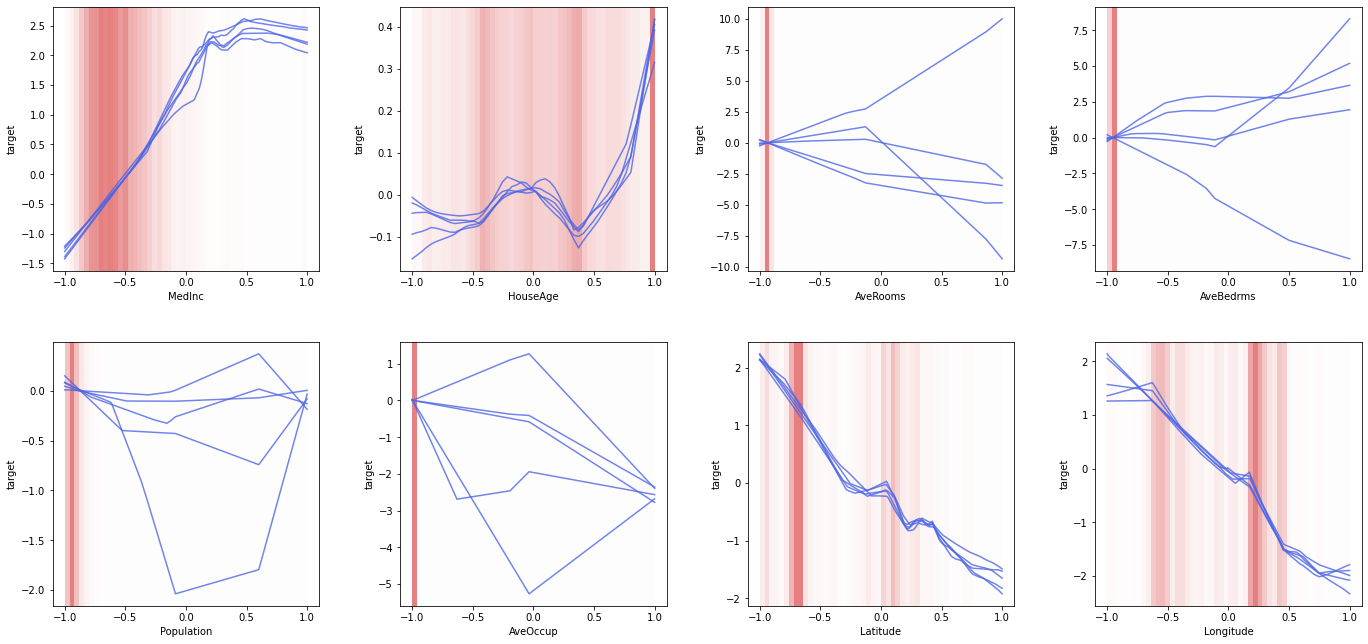

In [72]:
nam_plot(dataset, models)

In [73]:
graphing_dataset = NAMDataset.from_df(config,
                             housing_df, 
                             features_columns=housing.feature_names,
                             targets_column='target')

In [75]:
graphing_dataset.features = torch.tensor(np.array(graphing_dataset.data[housing.feature_names]).astype('float32'))

In [76]:
graphing_dataset.features_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

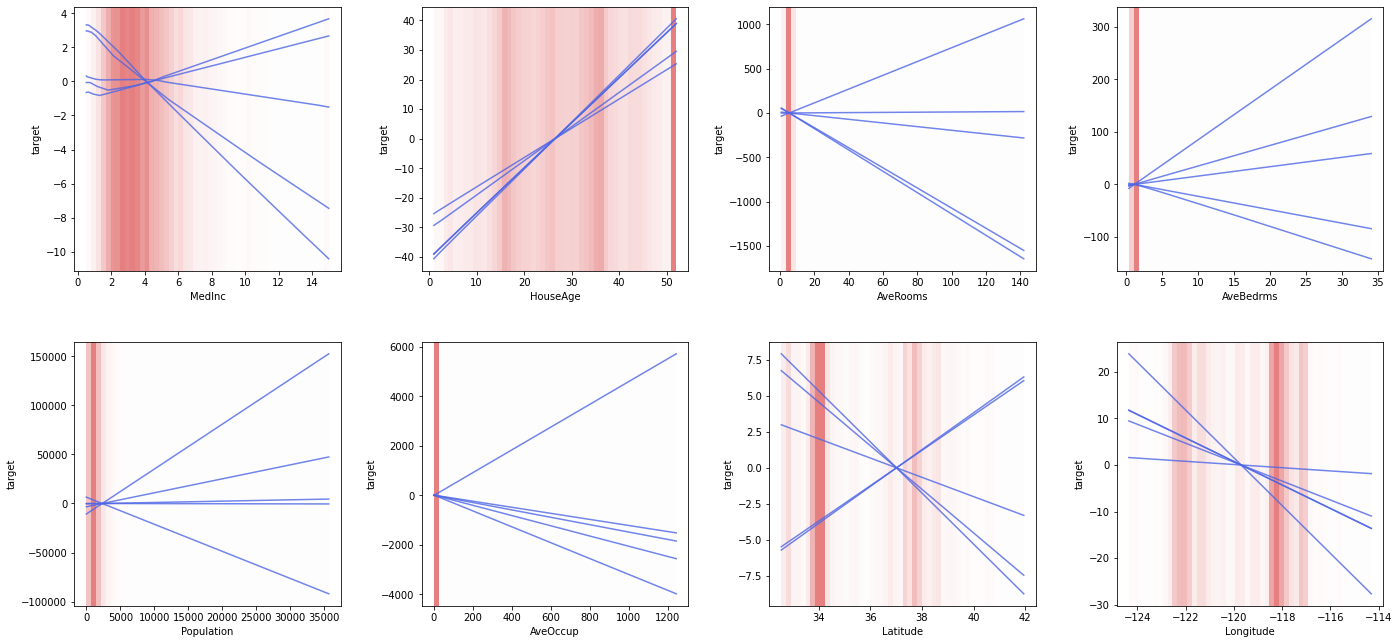

In [77]:
nam_plot(graphing_dataset, models)